<a href="https://colab.research.google.com/github/Sara1041/Thesis/blob/main/Part1_OneShotLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
from numpy import genfromtxt
import cv2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from sklearn.preprocessing import normalize
K.set_image_data_format('channels_first')
import random
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.utils import plot_model
import sys

2022-12-12 20:03:48.400636: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
train_path='train'
val_path = 'val'
test_path='test'

# Model

In [ ]:
def FinalModel(input_shape):
    model = tf.keras.applications.inception_v3.InceptionV3(include_top=False,input_shape=input_shape, weights=None)
    X = model.output
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(128, activation='relu',name='dense_layer')(X)
    X = tf.keras.layers.Lambda(lambda x:K.l2_normalize(x,axis=1),name='lambda_1')(X)

    model=Model(inputs=model.input,outputs=X,name='FingerRecognotionModel')
    return model

model=FinalModel(input_shape=(3,96,96))

# Defining the Triplet Loss Function

In [ ]:
def triplet_loss_t(y_true,y_pred):
    anchor=y_pred[:,0:128]
    pos=y_pred[:,128:256]
    neg=y_pred[:,256:384]
    positive_distance = K.sum(K.abs(anchor-pos), axis=1)
    negative_distance = K.sum(K.abs(anchor-neg), axis=1)
    probs=K.softmax([positive_distance,negative_distance],axis=0)
    loss=K.mean(K.abs(probs[0])+K.abs(1.0-probs[1]))
    return loss

### Function to resize the image to match the input shape of the model

In [ ]:
def localize_resize(path_image):
    image=cv2.imread(path_image)
    image=cv2.resize(image,(96,96))
    image=np.transpose(image,(2,0,1))
    image=image.astype('float32')/255
    return image

## Definig the generator

In [ ]:
def data_gen(path, batch_size=32):
    while True:
        i=0
        positive=[]
        anchor=[]
        negative=[]

        while(True):
            r=random.choice(os.listdir(path))
            id=os.listdir(path)
            ra=random.sample(id,2)
            pos_dir=path+'/'+ra[0]
            neg_dir=path+'/'+ra[1]
            pos=pos_dir+'/'+random.choice(os.listdir(pos_dir))
            anc=pos_dir+'/'+random.choice([x for x in os.listdir(pos_dir) if 'script' in x])
            neg=neg_dir+'/'+random.choice(os.listdir(neg_dir))

            pos_img=localize_resize(pos)
            neg_img=localize_resize(neg)
            anc_img=localize_resize(anc)

            positive.append(list(pos_img))
            negative.append(list(neg_img))
            anchor.append(list(anc_img))
            i=i+1
            if (i == batch_size):
                break
        #return anchor,positive,negative
        yield ([np.array(anchor),np.array(positive),np.array(negative)],np.zeros((batch_size,1)).astype("float32"))

## Defining model for triplet loss

In [ ]:
triplet_model_a=Input((3,96,96))
triplet_model_n=Input((3,96,96))
triplet_model_p=Input((3,96,96))
triplet_model_out=Concatenate()([model(triplet_model_a),model(triplet_model_p),model(triplet_model_n)])
triplet_model=Model([triplet_model_a,triplet_model_p,triplet_model_n],triplet_model_out)

In [ ]:
triplet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss=triplet_loss_t)

In [ ]:
triplet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 96, 96)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 3, 96, 96)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 3, 96, 96)]  0           []                               
                                                                                                  
 FingerRecognotionModel (Functi  (None, 128)         22065056    ['input_2[0][0]',                
 onal)                                                            'input_4[0][0]',            

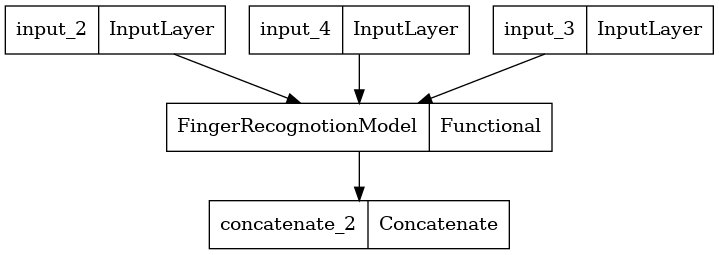

In [ ]:
plot_model(triplet_model)

### Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


bs = 60
train_gen = data_gen(train_path, bs)
val_gen = data_gen(val_path, bs)
test_gen = data_gen(test_path, bs)


epochs = 100
early_stop = EarlyStopping(patience=5)
history = triplet_model.fit(train_gen,
                            validation_data=val_gen,
                            steps_per_epoch=480//bs,
                            validation_steps=60//bs,
                            epochs=epochs, callbacks=[early_stop])

Epoch 1/100


2022-12-12 20:04:11.050628: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2022-12-12 20:04:12.081426: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


8/8 [==============================] - 21s 593ms/step - loss: 0.7593 - val_loss: 0.9896
Epoch 2/100
8/8 [==============================] - 1s 124ms/step - loss: 0.6821 - val_loss: 0.9889
Epoch 3/100
8/8 [==============================] - 1s 112ms/step - loss: 0.6543 - val_loss: 0.9767
Epoch 4/100
8/8 [==============================] - 1s 115ms/step - loss: 0.5882 - val_loss: 0.9536
Epoch 5/100
8/8 [==============================] - 1s 117ms/step - loss: 0.5020 - val_loss: 0.9108
Epoch 6/100
8/8 [==============================] - 1s 108ms/step - loss: 0.4620 - val_loss: 0.8181
Epoch 7/100
8/8 [==============================] - 1s 122ms/step - loss: 0.4467 - val_loss: 0.7313
Epoch 8/100
8/8 [==============================] - 1s 114ms/step - loss: 0.3777 - val_loss: 0.5803
Epoch 9/100
8/8 [==============================] - 1s 117ms/step - loss: 0.3495 - val_loss: 0.4970
Epoch 10/100
8/8 [==============================] - 1s 111ms/step - loss: 0.2712 - val_loss: 0.3874
Epoch 11/100
8/8 [==

In [ ]:
triplet_model.save('triplet_model.h5')

In [ ]:
triplet_model=tf.keras.models.load_model('triplet_model.h5',custom_objects={'triplet_loss_t':triplet_loss_t})
triplet_model.evaluate(test_gen, steps=60//bs)

1/1 [==============================] - 3s 3s/step - loss: 0.1274


0.12739866971969604

In [ ]:
#To loacaloze the face and resize the image
def image_resizing(image):
    image=cv2.resize(image,(96,96))

    return image

## Function to convert the image to embeddings.

In [ ]:
def encode_img(img1,triplet_model):
    #img1=cv2.imread(path,1)
    img=img1[...,::-1]
    img=np.around(np.transpose(img,(2,0,1))/255,decimals=12)
    x_train=np.array([img])
    emb=triplet_model.layers[3].predict_on_batch(x_train)
    return emb

## Function to calculate the distance between the embeddings and confidence score

In [ ]:
threshold=.7
interval=0.3
# Highest upper limit- Confidence, Reference of confidence=(threshold-max([dist,interval]))/(threshold-interval)
def confidence_value(ref_encode,img_encode,thres=threshold):
    #diff=np.max(img_encode-ref_encode)
    dist=np.linalg.norm((img_encode-ref_encode))
    #confidence=(1-K.eval(tf.minimum(dist,1)))
    confidence=(threshold-max([dist,interval]))/(threshold-interval)
    return dist,confidence

### For images of same person

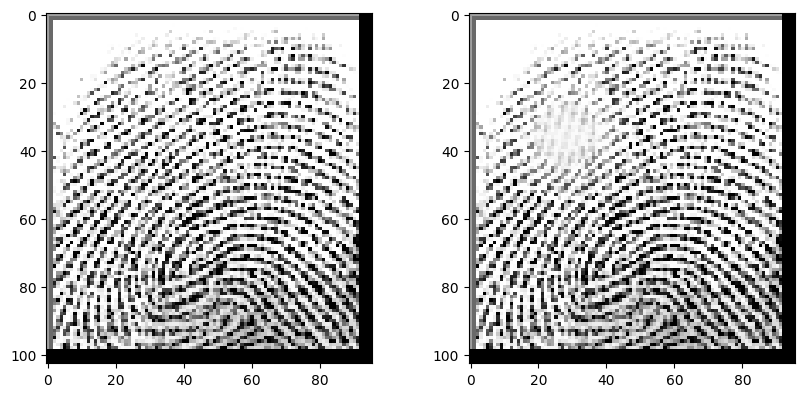

In [ ]:
n = 596
rimage=cv2.imread(f'test/{n}/{n}_script.BMP')
image=cv2.imread(f'test/{n}/{n}_CR.BMP')

fig=plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(rimage)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(image)

In [ ]:
n = 567
rimage=cv2.imread(f'test/{n}/{n}_script.BMP')
image=cv2.imread(f'test/{n}/{n}_CR.BMP')
image=cv2.imread(f'test/{n}/{n}_Obl.BMP')
image=cv2.imread(f'test/{n}/{n}_Zcut.BMP')
rimg=image_resizing(rimage)
img=image_resizing(image)
r_encode=encode_img(rimg,triplet_model)
img_encode=encode_img(img,triplet_model)
dist,conf=confidence_value(r_encode,img_encode)
if dist<threshold:
    print("Match with a confidence of ",conf*100)
else:
    print("No Match with a confidence of ",abs(conf*100))
print(dist)

Match with a confidence of  65.29850065708159
0.438806


### For images of different persons

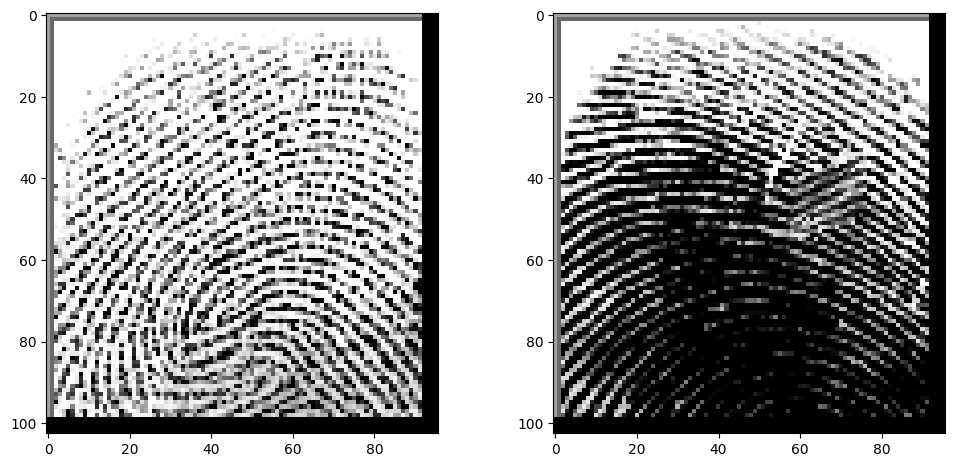

In [ ]:
r = 596
i = 597
rimage=cv2.imread(f'test/{r}/{r}_script.BMP')
image=cv2.imread(f'test/{i}/{i}_Zcut.BMP')

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(rimage)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(image)

In [ ]:
r = 596
i = 567
rimage=cv2.imread(f'test/{r}/{r}_script.BMP')
image=cv2.imread(f'test/{i}/{i}_CR.BMP')

#flowchart of our triplet function
rimg=image_resizing(rimage)
img=image_resizing(image)
r_encode=encode_img(rimg,triplet_model)
img_encode=encode_img(img,triplet_model)
dist,conf=confidence_value(r_encode,img_encode)
if dist<threshold:
    print(f"Match with a confidence of {conf*100}%",)
else:
    print(f"No Match with a confidence of {abs(conf*100)}%",)
print(dist)

No Match with a confidence of 99.76841211318973%
1.0990736


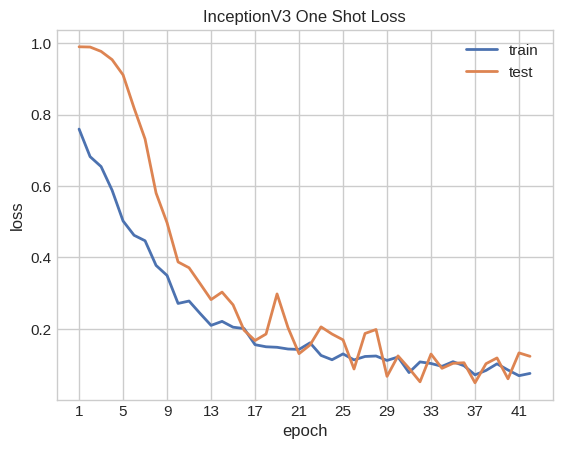

In [ ]:
import seaborn as sns

sns.set(font_scale=1)
plt.style.use('seaborn-whitegrid')
n = len(history.history['loss'])
plt.plot(range(1, n+1), history.history['loss'], linewidth=2)
plt.plot(range(1, n+1), history.history['val_loss'], linewidth=2)
plt.xticks(range(1, n+1, 4))
plt.title('InceptionV3 One Shot Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(f'InceptionV3.png', dpi=200, bbox_inches='tight')